In [ ]:
%tensorflow_version 1.x

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
import math

Using TensorFlow backend.


In [ ]:
image_list=os.listdir('/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/img')
image_list=[filename.split(".")[0]for filename in image_list]

print(image_list[0])

lineD16


In [ ]:
def visualize(img,seg_img, title1, title2):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title(title2)
    plt.show()

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
    
def get_segmented_img(img,n_classes):
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]
    seg_labels[:,:,0]=(img!=0).astype(int)
    return seg_labels


def pad_img(img):
	old_h,old_w=img.shape[0],img.shape[1]

	#Pad the height.

	#If height is less than 512 then pad to 512
	if old_h<512:
		to_pad=np.ones((512-old_h,old_w))*255
		img=np.concatenate((img,to_pad))
		new_height=512
	else:
	#If height >512 then pad to nearest 10.
		to_pad=np.ones((roundup(old_h)-old_h,old_w))*255
		img=np.concatenate((img,to_pad))
		new_height=roundup(old_h)

	#Pad the width.
	if old_w<512:
		to_pad=np.ones((new_height,512-old_w))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=512
	else:
		to_pad=np.ones((new_height,roundup(old_w)-old_w))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=roundup(old_w)-old_w
	return img


def pad_seg(img):
	old_h,old_w=img.shape[0],img.shape[1]

	#Pad the height.

	#If height is less than 512 then pad to 512
	if old_h<512:
		to_pad=np.zeros((512-old_h,old_w))
		img=np.concatenate((img,to_pad))
		new_height=512
	else:
	#If height >512 then pad to nearest 10.
		to_pad=np.zeros((roundup(old_h)-old_h,old_w))
		img=np.concatenate((img,to_pad))
		new_height=roundup(old_h)

	#Pad the width.
	if old_w<512:
		to_pad=np.zeros((new_height,512-old_w))
		img=np.concatenate((img,to_pad),axis=1)
		new_width=512
	else:
		to_pad=np.zeros((new_height,roundup(old_w)-old_w))
		img=np.concatenate((img,to_pad),axis=1)
		new_width=roundup(old_w)-old_w
	return img



def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/img/{fn}.jpg',0)
      img=pad_img(img)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      

      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/mask/{fn}_mask.png',0)
      seg=pad_seg(seg)
      seg=cv2.resize(seg,(512,512))
      seg = np.stack((seg,)*3, axis=-1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)


In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

model=unet()
model.summary()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
image_list[0]

'lineD16'

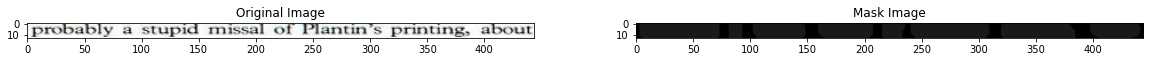

In [ ]:
img=cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/img/'+image_list[0]+'.jpg',1)
seg=cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/mask/'+image_list[0]+'_mask.png',1)

visualize(img,seg, "Original Image", "Mask Image")


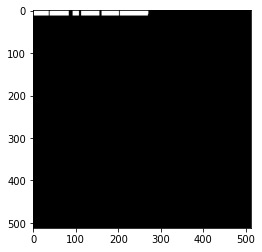

In [ ]:
img,seg=next(batch_generator(file_test,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')


In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('weights{epoch:08d}.h5', 
                                     save_weights_only=True, period=1)
model.fit_generator(batch_generator(file_train,2,2),epochs=5,steps_per_epoch=1000,validation_data=batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)


Epoch 1/5
1000/1000 [==============================] - 782s 782ms/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 0.0437 - val_accuracy: 0.9960
Epoch 2/5
1000/1000 [==============================] - 664s 664ms/step - loss: 0.0216 - accuracy: 0.9968 - val_loss: 0.0162 - val_accuracy: 0.9969
Epoch 3/5
1000/1000 [==============================] - 662s 662ms/step - loss: 0.0208 - accuracy: 0.9970 - val_loss: 0.0330 - val_accuracy: 0.9935
Epoch 4/5
1000/1000 [==============================] - 656s 656ms/step - loss: 0.0201 - accuracy: 0.9966 - val_loss: 0.0250 - val_accuracy: 0.9971
Epoch 5/5
1000/1000 [==============================] - 655s 655ms/step - loss: 0.0190 - accuracy: 0.9973 - val_loss: 0.0206 - val_accuracy: 0.9973


In [ ]:
file_test='/content/gdrive/MyDrive/Colab Notebooks/WordSegData2/Dataset1/img/lineA1.jpg'
img=cv2.imread(f'{file_test}',0)
img=pad_img(img)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img=np.expand_dims(img,axis=-1)
#img = np.stack((img,)*3, axis=-1)
img=img/255

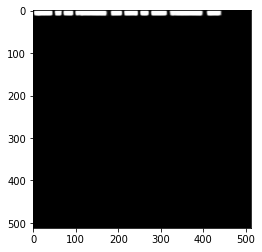

In [ ]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [ ]:
plt.imsave('test_img_mask.JPG',pred)